# ULMFiT--Twitter US Airlines Sentiment

# Goal
Create ULMFiT model to predict Twitter US Airlines Sentiment

# Overview of ULMFiT

ULMFiT is a transfer learning technique that essentially uses a pre-trained model's weights as a starting point for training a new model with similar input data. The ideas is that pre-trained weights capture dataset abstractions that generalize well to a similar field, and therefore leads to more accurate predictions compared to completely new models.

# EDA

In [1]:
import os
import numpy as np
import pandas as pd
from fastai.text import * 

In [11]:
#Setting path for learner
path = Path(os.path.abspath(os.curdir))

In [47]:
#reading into pandas and renaming columns for easier api access
filepath = Path('/home/ubuntu/Notebooks/tweet-stance-prediction-master')
df = pd.read_csv(filepath/'tweets.csv')
df.rename(columns={'airline_sentiment':'label'},inplace=True)


In [48]:
# how many records
len(df)

14640

In [49]:
df['label'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: label, dtype: int64

So there is class imbalance here. We can expect that predictions will be biased towards the majority class--negative.

In [51]:
df['text'].isna().sum()

0

In [59]:
df = df[['label','text']]
df.head(2)

,label,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...


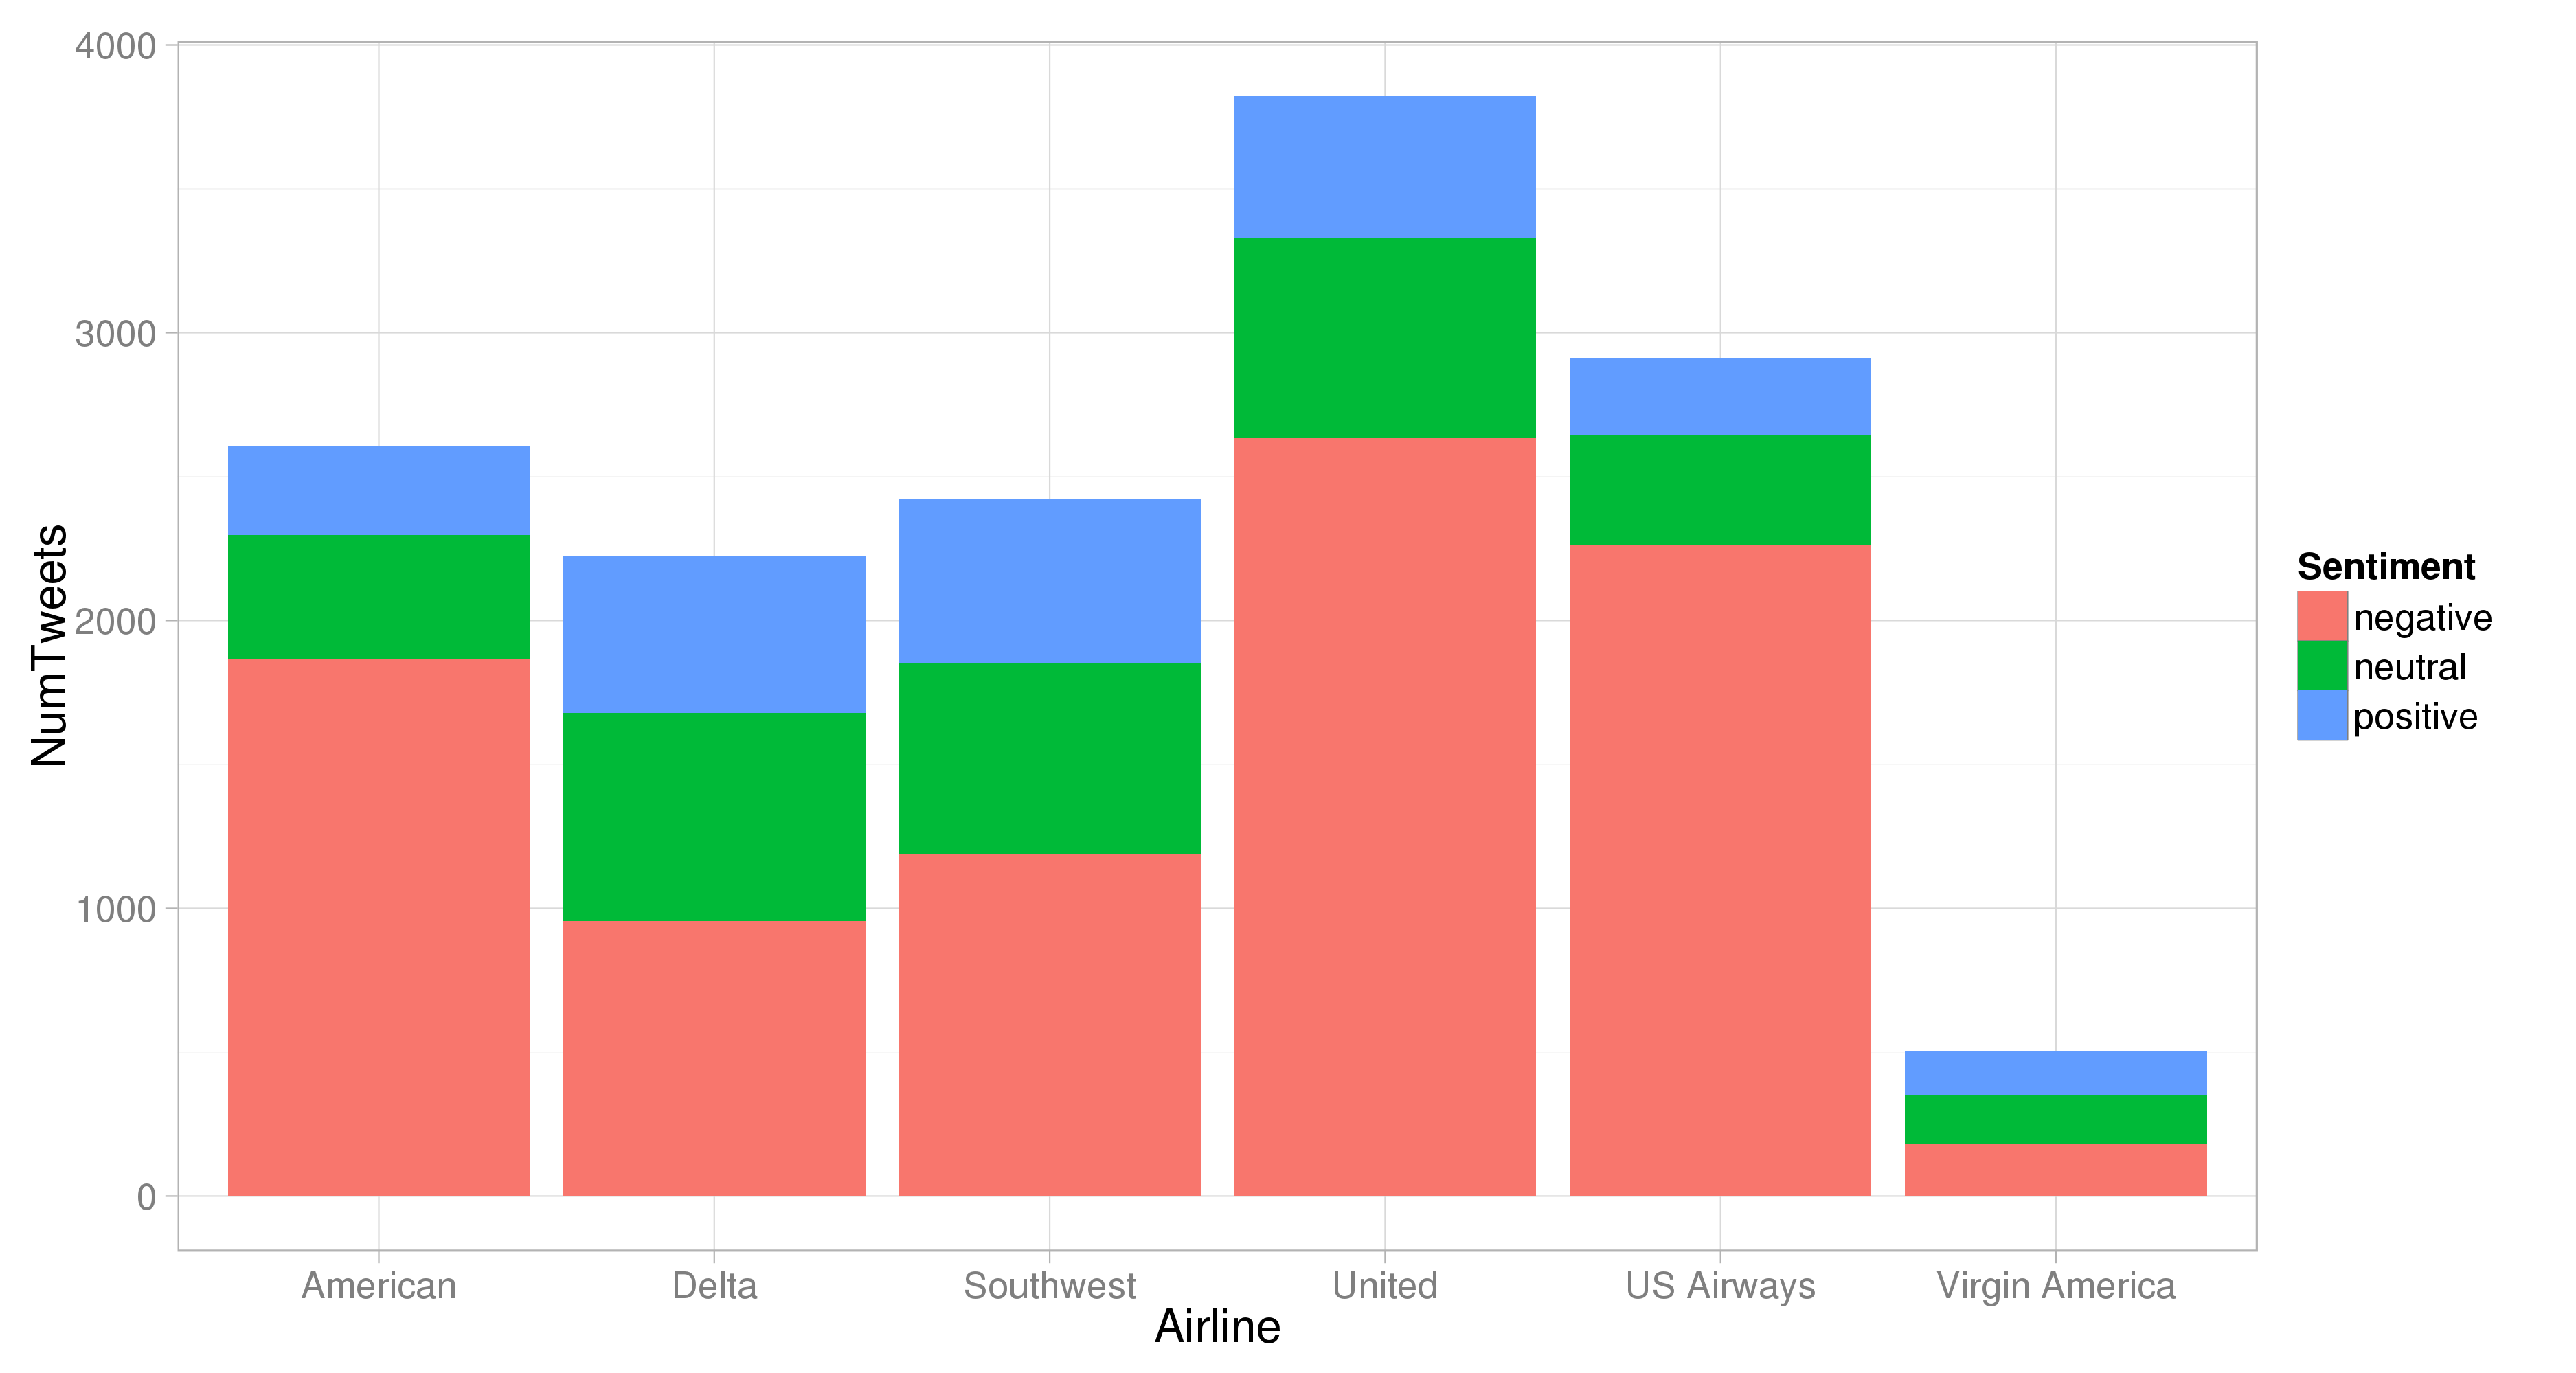

In [58]:
from IPython.display import Image
Image("https://www.kaggle.io/svf/136065/a6e055ee6d877d2f7784dc42a15ecc43/airlineSentimentPlot.png")

So, most classes in the dataset are 'negative', and most airlines are represented well except for 'Virgin America'. One way we could possibly improve results is by downsampling the 'negative' class. The fact that Virgin America is represented less than other airlines may not be an issue--my hypothesis is that negative tweets generalize across airlines, so the imbalanced representation is not a concern.

# Train language model

Split the dataset into 80/10/10 train/validate/test

In [60]:
train = df[:int(len(df)*.8)]
valid = df[int(len(df)*.8):int(len(df)*.9)]
test = df[int(len(df)*.9):]

Create a PyTorch 'DataBunch' object from the train and validation datasets. This proceses the Tweet data into a format readable by the pre-trained language model we are about to fine-tune. 

The pre-trained language model is an AWD-LSTM trained on Wikitext-103 dataset, which contains 28.5k Wikipedia articles totaling 103m words. 

AWD-LSTM is a variant of LSTM that utilizes DropConnect (randomly change some layer weights to 0) and Average Stochastic Gradient Descent (average latest gradient weights with previous ones if the latest updates don't improve the model loss).

In [20]:
# Language model data
data_lm = TextLMDataBunch.from_df(path, train, valid)
data_lm.save('data_lm_export.pkl')
data_lm = load_data(path, 'data_lm_export.pkl')

Set up the language model

In [30]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

In [25]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(5848, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(5848, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=5848, bias=True)
   (output_dp): RNNDropout()
 )]

Find the optimal learning rate for our model. We want to use a learning rate that is a bit before the minimum, where loss still improves.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


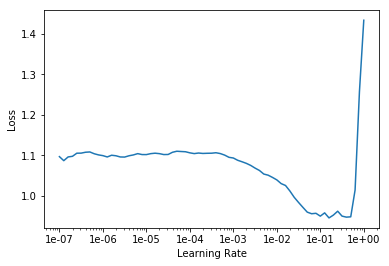

In [66]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

Train model using the optimal learning rate. We will use a one-cycle learning policy which increases learning rate, then decreases it right before the last epoch. This seems to increase accuracy.

In [34]:
learn = language_model_learner(data_lm, AWD_LSTM, 
                               drop_mult=0.5)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.115088,5.652101,0.168676,02:00


In [35]:
# fine-tune, so unfreeze all layers
## try another quicker method--changed cycle len to 5 for time

learn.unfreeze()
learn.fit_one_cycle(cyc_len=5, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.932775,4.339819,0.244221,03:29
1,4.311536,4.053621,0.261607,03:29
2,3.941757,3.945170,0.270858,03:28
3,3.709489,3.895653,0.277852,03:28
4,3.557175,3.891744,0.277058,03:28


In [61]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

# Train classifier

Create Databunch input for classifier model.

In [63]:
# create classifier dataloader
# data_clas = TextClasDataBunch.from_csv(path, 'train_topic.csv', vocab=data_lm.train_ds.vocab,
#                                        min_freq=1, bs=32)
data_clas = TextClasDataBunch.from_df(path, train, valid, vocab=data_lm.train_ds.vocab, bs=32)
data_clas.save()

In [65]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


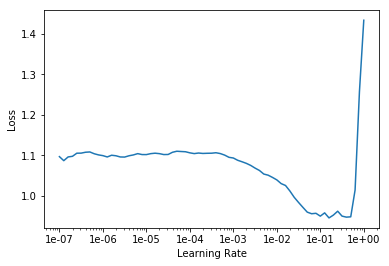

In [66]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

Now, we will apply gradual unfreezing to prevent catastrophic forgetting. This reduces layer weight updates so that abstractions are still kept in memory and used for making predictions.

In [67]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7)) # slice and momentum are specified to adjust learning rate and momentum per one-cycle methodology

epoch,train_loss,valid_loss,accuracy,time
0,0.674057,0.561209,0.786202,01:38


In [68]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.636009,0.504748,0.796448,02:08


In [69]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.589561,0.473432,0.812158,03:55


In [70]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.508486,0.462486,0.823087,05:22
1,0.520242,0.455615,0.825137,05:16
2,0.472421,0.456078,0.831284,05:20
3,0.418493,0.461909,0.827186,05:12


# Test classifier

This is where I would post results--precision, recall, and F1-Score.

# Analyze results and re-train the model

Based on results, I would re-engineer the dataset and re-train the models. My assumption is that since the dataset is negative-biased, the predictions will be biased towards negative. In this case, I would downsample the negative records and retrain the model so that the model will not be as biased and be better able to tease out patterns in the other classes. 